In [2]:
from utils import *
from efficientnet_pytorch import EfficientNet
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from scipy import ndimage

# Gaussian Filter

In [3]:
BATCH_SIZE = 12
NUM_EPOCHS = 15
SAVE_EVERY = 5
VAL_EVERY = 5

In [71]:
train_experiments = ['HEPG2-01', 'HEPG2-03', 'HEPG2-05', 'HEPG2-07']
val_experiments = [ 'HEPG2-06']
test_experiments = ['HEPG2-02', 'HEPG2-04']

train_df = pd.read_csv(os.path.join(RECURSION_TRAIN_DIR, 'train.csv'))
train_df['cell_line'] = [v[0] for v in train_df.id_code.str.split('-')]
train_df = train_df[train_df['cell_line'] == 'HEPG2']
train_dfs = []
for site in range(2):
    cp = train_df.copy()
    cp['site'] = site+1
    train_dfs.append(cp)
train_df = pd.concat(train_dfs)
test_df = train_df.query('experiment in @test_experiments')
test_df = test_df.reset_index(drop=True)
train_df = train_df.query('experiment in @train_experiments')
train_df = train_df.sample(frac=1).reset_index(drop=True) #SHUFFLE

In [72]:
class RxRx1(Dataset):
    def __init__(self, df, is_train_dataset=True, img_filter=None, param=None):
        self.df = df
        self.is_train_dataset = is_train_dataset
        self.img_filter = img_filter
        self.param = param
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        row = self.df.loc[idx]
        exp, well, plate, site = row.experiment, row.well, row.plate, row.site
        img_channels = [read_image(get_image_path(exp, plate, well, site, ch, train=True)) for ch in range(1,7)]
        img = np.stack(img_channels, axis=2).T
        
        # Set image filter type
        if self.img_filter is None:
            pass
        elif self.img_filter == 'gaussian_hp': # Gaussian high-pass filter
            std = self.param
            img = img - ndimage.gaussian_filter(img, std)
        elif self.img_filter == 'mean': # Mean filter
            R = np.ones((3, 3)) / 9
            img = ndimage.convolve(img, R)
        elif self.img_filter == 'high_pass': #High-pass filter
            c = self.param
            R = np.array([[-1, -1, -1],[-1, 8, -1],[-1, -1, -1]])
            img = ndimage.convolve(img, R)
        img = torch.tensor(img)
        
        if self.is_train_dataset:
            return img, np.array([row.sirna.astype('int32')])            
        return img

In [73]:
org_img = np.array([[1,1,1,1],[1,1,1,1],[1,1,1,1],[1,1,1,1]])
R = np.array([[-1, -1, -1],[-1, 8, -1],[-1, -1, -1]])
res_img = ndimage.convolve(org_img, R)
print(res_img)

[[0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]
 [0 0 0 0]]


In [74]:
def gaussian_filter(img, sigma=10):
    return ndimage.gaussian_filter(img, sigma=sigma)

In [75]:
def median_filter(img, size=10):
    return ndimage.median_filter(img, size=size)

In [76]:
def gaussian_highpass_filter(img, sigma):
    return img - ndimage.gaussian_filter(img, sigma=sigma)

In [77]:
def ben_color(image, sigmaX=10):
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     image = crop_image_from_gray(image)
#     image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
    image=cv2.addWeighted ( image,4, cv2.GaussianBlur( image , (0,0) , sigmaX) ,-4 ,128)
        
    return image

In [78]:
train_set = RxRx1(train_df)
test_set = RxRx1(test_df)

In [79]:
img = x[0].numpy()[0]

In [80]:
for x in train_set:
    break

In [81]:
train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=10)

In [82]:
test_loader = DataLoader(dataset=test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=10)

In [83]:
data, target = next(iter(train_loader))

In [84]:
print(data.shape, target.shape)

torch.Size([12, 6, 512, 512]) torch.Size([12, 1])


In [85]:
def baseline_model(num_classes=1108):
    model = EfficientNet.from_pretrained('efficientnet-b0', num_classes=num_classes)
    trained_kernel = model._conv_stem.weight
    new_conv = nn.Sequential(nn.Conv2d(6, 32, kernel_size=(3,3), stride=(2,2), bias=False),
                nn.ZeroPad2d(padding=(0, 1, 0, 1)))
    with torch.no_grad():
        new_conv[0].weight[:,:] = torch.stack([torch.mean(trained_kernel, 1)]*6, dim=1)
    model._conv_stem = new_conv
    return model

In [86]:
def evaluate(model, test_loader):
    model.cuda()
    predictions = []
    truth = []
    for i, (data, target) in tqdm(enumerate(test_loader), total=len(test_loader)):
        data, target = data.cuda(), target[:,0].long().cuda()
        with torch.no_grad():
            outputs = model(data)
        predictions.append(outputs.argmax(dim=1).cpu().numpy())
        truth.append(target.cpu().numpy())

    truth = np.array(truth).flatten()
    predictions = np.array(predictions).flatten()
    return np.mean(truth == predictions)

In [87]:
def train(model, train_loader, num_epochs=NUM_EPOCHS, timestamp=None, test_loader=None):
    history = {}
    if timestamp is None:
        timestamp = datetime.now().strftime("%m-%d_%H-%M")
    history['timestamp'] = timestamp
    history['loss'] = []
    history['accuracy'] = {}
    log_dir = os.path.join(LOG_DIR, 'baseline_{}'.format(timestamp))
    if not os.path.exists(log_dir):
        os.mkdir(log_dir)
    model = model.cuda()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    
    for epoch in range(num_epochs):
        print(f'--------EPOCH {epoch+1}--------')
        for i, (data, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
            data, target = data.cuda(), target[:,0].long().cuda()
            #print(data.shape)
            outputs = model(data)
            loss = criterion(outputs, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            history['loss'].append(loss.detach().cpu().numpy())

            if (i+1) % 100 == 0:
                print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                     .format(epoch+1, num_epochs, i+1, len(train_loader), loss.item()))

        
        if (epoch + 1) % VAL_EVERY == 0:
            if test_loader is not None:
                print('Evaluating model.')
                history['accuracy'][epoch+1] = evaluate(model, test_loader)
                print('{:.3f}'.format(history['accuracy'][epoch+1]))


        if (epoch + 1) % SAVE_EVERY == 0:
            print('Creating a checkpoint.')
            torch.save(model.state_dict(), os.path.join(log_dir, 
                                                        'baseline_{:02}.pt'.format(epoch+1)))
    return history

In [88]:
# model.load_state_dict(torch.load(os.path.join(DUMP_DIR, 'baseline-15.pt')))

In [89]:
# print('{:.4f}'.format(np.mean(truth == predictions)))

In [90]:
def train_filter(img_filter, param):
    # Set train_loader with filter
    train_set = RxRx1(train_df, img_filter=img_filter, param=param)
    train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=10)

    model = baseline_model()
    hist = train(model, train_loader=train_loader, test_loader=test_loader)
    return hist

In [91]:
train_set = RxRx1(train_df, img_filter='gaussian_hp')
train_loader = DataLoader(dataset=train_set, batch_size=BATCH_SIZE, shuffle=True, num_workers=10)

In [92]:
test_set = RxRx1(test_df, img_filter='gaussian_hp')
test_loader = DataLoader(dataset=test_set, batch_size=BATCH_SIZE, shuffle=False, num_workers=10)

In [93]:
histories = []
for i in range(10):
    model = baseline_model()
    hist = train(model, train_loader=train_loader, test_loader=test_loader)
    histories.append(hist)

Loaded pretrained weights for efficientnet-b0
--------EPOCH 1--------


TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/kaandonbekci/anaconda3/envs/recursion/lib/python3.6/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/kaandonbekci/anaconda3/envs/recursion/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/kaandonbekci/anaconda3/envs/recursion/lib/python3.6/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "<ipython-input-72-8c78e1020dd1>", line 22, in __getitem__
    img = img - ndimage.gaussian_filter(img, std)
  File "/home/kaandonbekci/anaconda3/envs/recursion/lib/python3.6/site-packages/scipy/ndimage/filters.py", line 295, in gaussian_filter
    for ii in range(len(axes)) if sigmas[ii] > 1e-15]
  File "/home/kaandonbekci/anaconda3/envs/recursion/lib/python3.6/site-packages/scipy/ndimage/filters.py", line 295, in <listcomp>
    for ii in range(len(axes)) if sigmas[ii] > 1e-15]
TypeError: '>' not supported between instances of 'NoneType' and 'float'


In [ ]:
for hist in histories:
    print(hist['accuracy'])

In [52]:
accuracies = [[] for i in range(10)]
for i, h in enumerate(histories):
    for e in h['accuracy']:
        accuracies[i].append(h['accuracy'][e])

In [9]:
import numpy as np

accuracies = [[0.163279, 0.21793134, 0.2337398],[0.186766, 0.205962059, 0.21364046],[0.1734417, 0.21318879, 0.2206413],[0.223803, 0.2461607, 0.26038843],[0.19354, 0.2242547, 0.23870822],[0.1860885275519422, 0.23441734417344173, 0.22606142728093948],[0.1537940379403794, 0.1910569105691057, 0.186766034327009],[0.17411924119241193, 0.20957542908762422, 0.21386630532971995],[0.19670280036133694, 0.243676603432701, 0.23893405600722],[0.16531165311653118, 0.1937669376693767, 0.19263775971093045]]

accuracies = np.array(accuracies)
mean_accuracies = accuracies.mean(axis=0)
std_accuracies = accuracies.std(axis=0)

In [10]:
{5: 0.1632791327913279, 10: 0.21793134598012648, 15: 0.23373983739837398}
{5: 0.18676603432700994, 10: 0.20596205962059622, 15: 0.21364046973803072}
{5: 0.17344173441734417, 10: 0.21318879855465223, 15: 0.22064137308039747}
{5: 0.22380307136404698, 10: 0.24616079494128273, 15: 0.2603884372177055}
{5: 0.19354110207768743, 10: 0.22425474254742547, 15: 0.2387082204155375}
{5: 0.1860885275519422, 10: 0.23441734417344173, 15: 0.22606142728093948}
{5: 0.1537940379403794, 10: 0.1910569105691057, 15: 0.18676603432700994}
{5: 0.17411924119241193, 10: 0.20957542908762422, 15: 0.21386630532971995}
{5: 0.19670280036133694, 10: 0.243676603432701, 15: 0.23893405600722675}
{5: 0.16531165311653118, 10: 0.1937669376693767, 15: 0.19263775971093045}

{5: 0.16531165311653118, 10: 0.1937669376693767, 15: 0.19263775971093045}

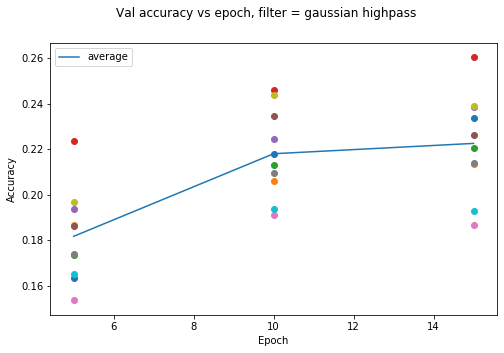

In [13]:
import matplotlib.pyplot as plt

x = np.arange(5, 16, 5)
fig = plt.figure(figsize=(8, 5))
plt.suptitle('Val accuracy vs epoch, filter = gaussian highpass')
plt.plot(x, mean_accuracies, label='average')
for i in range(10):
    plt.scatter(x, accuracies[i])
plt.xlabel('Epoch')
plt.legend()
_=plt.ylabel('Accuracy')

In [56]:
mean_accuracies

array([0.18168473, 0.2179991 , 0.22253839])